In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as plot_style
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

['/home/francesco/Developing/Integrated_Actin/virtual_lab/examples',
 '/home/francesco/miniconda3/envs/b2l/lib/python310.zip',
 '/home/francesco/miniconda3/envs/b2l/lib/python3.10',
 '/home/francesco/miniconda3/envs/b2l/lib/python3.10/lib-dynload',
 '',
 '/home/francesco/miniconda3/envs/b2l/lib/python3.10/site-packages',
 '/home/francesco/Developing/Integrated_Actin/virtual_lab']

In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
from examples.required_files.const import *
from examples.required_files.experiment_list import *
from examples.required_files.models import *
from virtual_lab.logger import *
Sim = Simulation()
Sim.save_figs = False
VL_Logger.set_log_level(LogLevel.DIAGNOSTIC)

Set log level to DIAGNOSTIC


In [4]:
variable_labels = {
    "Vpsd": r'$V_{PSD}$',
    "V_tot": r'$V_{tot}$',
    "Vd": r'$V_d$',
    "Vs": r'$V_s$',
    "V_eff": r'$V_{eff}$',
    "Ve": r'$V_m$', 
    "crosslink": 'cross.',
    "stim": "HFS"
}

# Trying out different models

## Model with normal $V_d$ non linearity and $V_eff$

In [5]:
# Making the constants optimal for this model
def compute_analytical_approx(gamma,mu,nf_0,delta_t):
    a = gamma/mu
    b = 1/(mu*delta_t)*((gamma/mu-nf_0)*(np.exp(-mu*delta_t)-1))
    return a+b
const_base = CONSTANTS.copy()
gamma = const_base["gamma_0"]*const_base["g_mul_LTP"]
mu = const_base["mu_0"]*const_base["m_mul_LTP"]
print(gamma/mu)
nf_aa = compute_analytical_approx(gamma,mu,const_base["nf_0"],const_base["STET"])
print(nf_aa)
const_base.update({
    "tau_Vd" : 9000,
    # Crosslinker binding rates
    "k_u_0" : 1/2/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    "nf_0" : 0.055,
    "nf_LTP": nf_aa,
    })
base_model = BaseModel("Base", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                        labels = variable_labels)
base_model.experiments = create_experiments(base_model)
Sim.add_model(base_model)

16.200000000000003
12.233995181110489
INFO Simulation: Switching to model Base
DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json


## Momentum Model

DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json


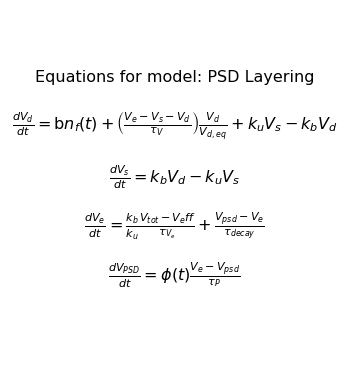

In [7]:
# Optimizing constants for this model
const_momentum = CONSTANTS.copy()
enlarge_dict = {# Enlargement pool
    # Crosslinker binding rates
    "k_u_0" : 1/2.5/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2.5/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    "tau_add_Ve":5400, #5400
    "tau_Ve": 3300, # 33000
    # Dynamic pool timescale
    "tau_Vd": 4800,
    "nf_LTP": nf_aa} # 4800
const_momentum.update(enlarge_dict)
mom_model = MomentumModel("PSD Layering",{"Vd": None, "Vs": None, "Vpsd": 1., "V_eff": None,"V_tot": None,"Ve": None}, 
                            const = const_momentum,labels = variable_labels)
mom_model.experiments = create_experiments(mom_model)
Sim.add_model(mom_model,switching=False)
Sim.model_equations(["PSD Layering"])

# Early consolidation model

In [8]:
early_consolidation = BaseModel("EC", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                                labels = variable_labels)
early_consolidation.P_ONSET = 12.5 * 60
early_consolidation.nf_0 = 0.04
early_consolidation.nf_LTP = 15.2
early_consolidation.tau_Vd = 8000
early_consolidation.experiments = create_experiments(early_consolidation)
Sim.add_model(early_consolidation,switching=False)

DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json


# Running Experiments & Comparison

In [9]:
#mom_model.stop_recording_variables("V_eff")
LTP_LTD_NAMES = ["S_TET","LTD","W_TET", "W_LFS",]
M_NAMES = ["LTP_X2","MULTI_LTP_BEFORE_PRP"]
exp_name = "NO_STIMULI"
exp_title = "Weak HFS"
exp_multi_title = ["STC LTP SBW", "STC LTD SBW"]
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    multiple = [Sim.models[model].experiments["Basic"].get_experiment(name) for name in M_NAMES]
    ltp_ltd = [Sim.models[model].experiments["Basic"].get_experiment(name) for name in LTP_LTD_NAMES]
    stc_base = [Sim.models[model].experiments["STCLTP"][k] for k in range(len(Sim.models[model].experiments["STCLTP"]))]
    for k in range(len(Sim.models[model].experiments["STCLTD"])):
        stc_base.append(Sim.models[model].experiments["STCLTD"][k])
    extended = [exp for exp in ltp_ltd]
    for k in range(len(stc_base)):
        extended.append(stc_base[k])
    cplx_stc = Sim.models[model].experiments["TR"]
    single_exp = Sim.models[model].experiments["Basic"].get_experiment(exp_name)
    if not isinstance(single_exp,Experiments):
        single_exp.title = exp_title
    else:
        for i,exp in enumerate(single_exp):
            exp.title = exp_multi_title[i]
    _ = Sim.run_experiments(single_exp,n_of_runs=10,stochastic=True,termalize=True,record_termalization=False)
    # #Adding a reference for TR experiments
    # ltp_results = Sim.run_experiments(single_exp,save_results=False)
    # for n in [0,1]:
    #     Sim.model_results[model][n]["V_tot_ref"] = ltp_results[0]["V_tot"]
    #     Sim.model_results[model][n]["Vpsd_ref"] = ltp_results[0]["Vpsd"]
    #     Sim.model.labels["V_tot_ref"] = r'$V_{tot,LTP}$'
    #     Sim.model.labels["Vpsd_ref"] = r'$V_{PSD,LTP}$'

INFO Simulation: Simulating 1 experiments took: 105.718 s
INFO Simulation: Simulating 1 experiments took: 106.564 s


In [10]:
# Sim.switch_model("PSD Layering")
# Sim.plot_results(time_interval = [0,3600],filename="W_TET_detail-PSD_Layerinh.png")

INFO Simulation: Plotting 2 experiments
DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json
DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json


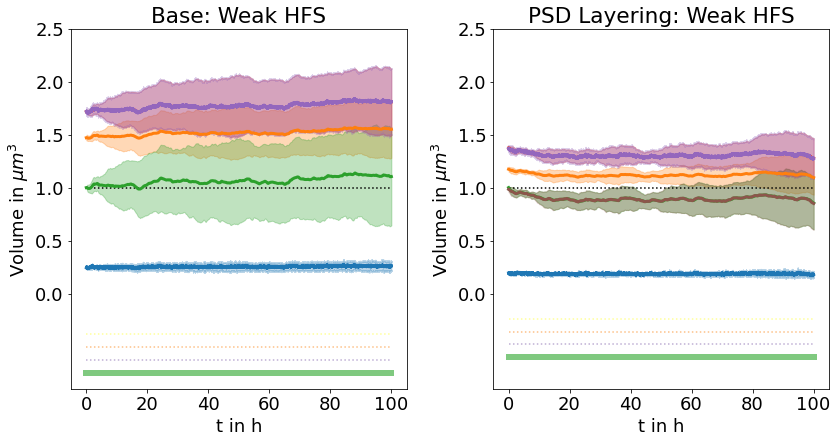

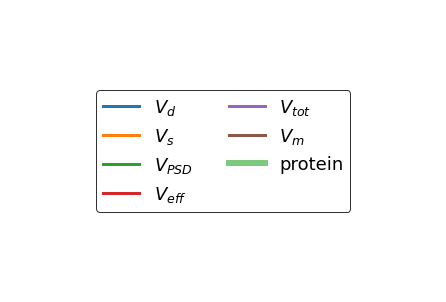

In [11]:
Sim.plot_comparison(filename = f"{exp_name}_all_models.png", time_unit = 'h',
fontsize = 18,use_title = True,separate_legend = True)

# $V_{tot}$ vs $V_{PSD}$ as in Meyer et al. 2014 

DOI:10.1016/j.neuron.2014.02.031.

INFO Simulation: Simulating 1 experiments took: 0.448 s
INFO Simulation: Simulating 1 experiments took: 0.496 s
INFO Simulation: Simulating 1 experiments took: 0.794 s


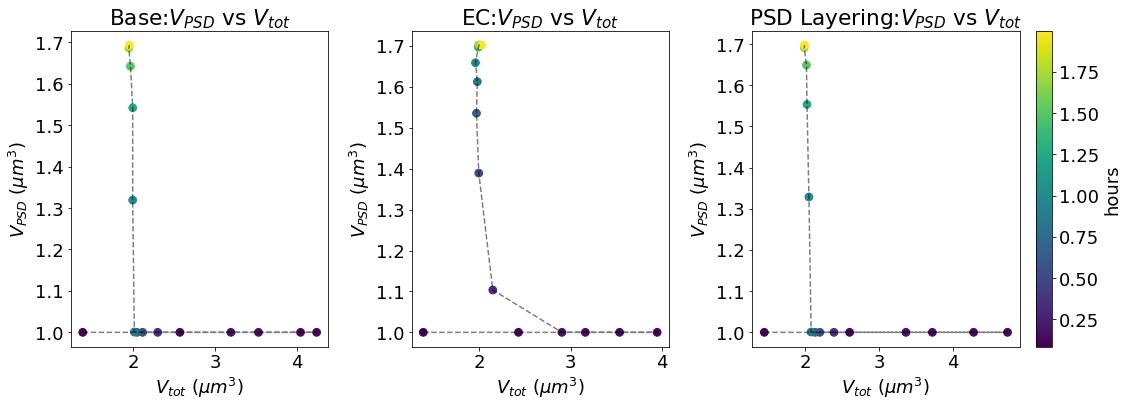

In [12]:
import matplotlib.collections as mcoll
from itertools import chain

time_points = [[k for k in range(5*60,10*60,60)]]
time_points.append([k for k in range(10*60,3600,600)])
time_points.append([3600,int(75/60*3600),int(1.5*3600),int(105/60*3600),2*3600-1])
time_points = np.array([item for sublist in time_points for item in sublist])
Vtot = []
Vpsd = []
for i,model in enumerate(["Base","EC","PSD Layering"]):
    results = Sim.run_experiments(Sim.models[model].experiments["Basic"].get_experiment("S_TET"),n_of_runs=1,stochastic=True,termalize=True,record_termalization=False)
    Vpsd.append(results[0]["Vpsd"][time_points])
    Vtot.append(results[0]["V_tot"][time_points])
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1,1,1.3]},figsize = (16,6))
for i,model in enumerate(["Base","EC","PSD Layering"]):
    fig.add_subplot(1,3,i+1)
    ax[i].set_axis_off()
    plt.plot(Vtot[i],Vpsd[i],c = "k",alpha = 0.5,ls = '--')
    plt.scatter(Vtot[i],Vpsd[i], c = time_points/3600, cmap = "viridis",s = 60)
    plt.title(f"{model}:"+r'$V_{PSD}$ vs $V_{tot}$')
    plt.xlabel(r"$V_{tot}$ ($\mu m^3$)")
    plt.ylabel(r"$V_{PSD}$ ($\mu m^3$)")
    if i == 2:
        cb = plt.colorbar()
        cb.set_label("hours")
    plt.tight_layout()
plt.savefig("plots/vpsd-vs-vtot_all_models.png")
plt.show()

In [14]:
exp_names = ["NO_STIMULI","S_TET"]
Sim.switch_model("Base")
stoch_det_results = []
for name in exp_names:
    exp = Sim.model.experiments["Basic"].get_experiment(name)
    stoch = Sim.run_experiments(exp,100,stochastic=True,termalize = True)
    det = Sim.run_experiments(exp)
    stoch_det_results.append([stoch[0],det[0]])

INFO Simulation: Simulating 1 experiments took: 106.159 s
INFO Simulation: Simulating 1 experiments took: 0.504 s
INFO Simulation: Simulating 1 experiments took: 31.303 s
INFO Simulation: Simulating 1 experiments took: 0.103 s


In [ ]:
# mean_stoch = np.mean(stoch_det_results[0][0]["V_tot"])
# std_stoch = np.std(stoch_det_results[0][0]["V_tot"])
# mean_det =stoch_det_results[0][1]["V_tot"][-1] 
# print(mean_stoch,std_stoch,mean_det)
# Sim.compare_experiment_results(stoch_det_results[0],["V_tot"], figsize = (12,6),stochastic_styling = "mean_traces_1",
# rescale = True, time_unit = "h",filename = f"NO_STIMULI-stoch-det.png",use_legend = True,multi_plot=1,
# xlabel = "t in hours", ylabel = r"$V_{tot}$ in $\mu m^3$")

2.4871208960415605 0.5418130089572423
DEBUG Simulation: Saving user preferences to usr_prefs/user_prefs.json


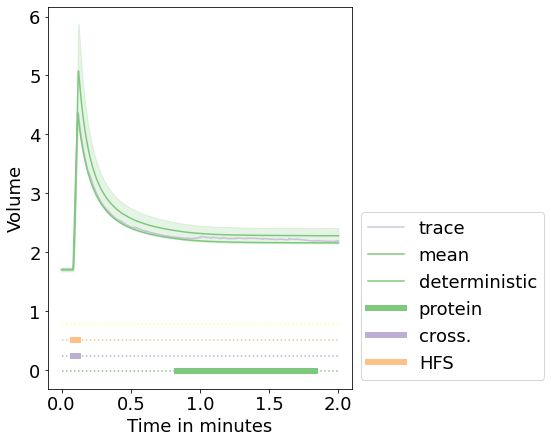

In [15]:
mean_stoch = np.mean(stoch_det_results[1][0]["V_tot"])
std_stoch = np.std(stoch_det_results[1][0]["V_tot"])
print(mean_stoch,std_stoch)
Sim.compare_experiment_results([stoch[0],det[0]],["V_tot"],stochastic_styling = "mean_traces_1",
 rescale = True, time_unit = "h",filename = "LTP-stoch-det.png",use_legend = True)

# Tag reset experiments comparison

In [ ]:
do_not_record = {
    "Vd" : False,
    "Vs" : False,
    "V_eff": False
}
# TODO allow for comparison of different model results!
tr_results = []
reference_values=[]
x_data = []
for idx,model in enumerate(["Base","EC","PSD Layering"]):
    # Sim.models[model].stop_recording_variables(do_not_record)
    Sim.switch_model(model)
    tr_results.append(Sim.run_experiments(Sim.model.experiments["TR_extended"],save_results=False))
    reference_LTP = Sim.run_experiments(Sim.model.experiments["Basic"].get_experiment("S_TET"))
    x_data = np.array([tr_results[idx][i]["experiment"].LFS[0][0] -300 for i in range(len(tr_results[idx]))])/60
    # Take as reference the value of the PSD after potentiation
    reference_values.append([reference_LTP[0]["Vpsd"][-1],1])


Simulating 29 experiments took: 1.262 s
Simulating 1 experiments took: 0.126 s
Simulating 29 experiments took: 1.150 s
Simulating 1 experiments took: 0.116 s
Simulating 29 experiments took: 1.488 s
Simulating 1 experiments took: 0.148 s


Making 1 plots
Figsize (18, 6.5)
Making 1 plots
Making 1 plots


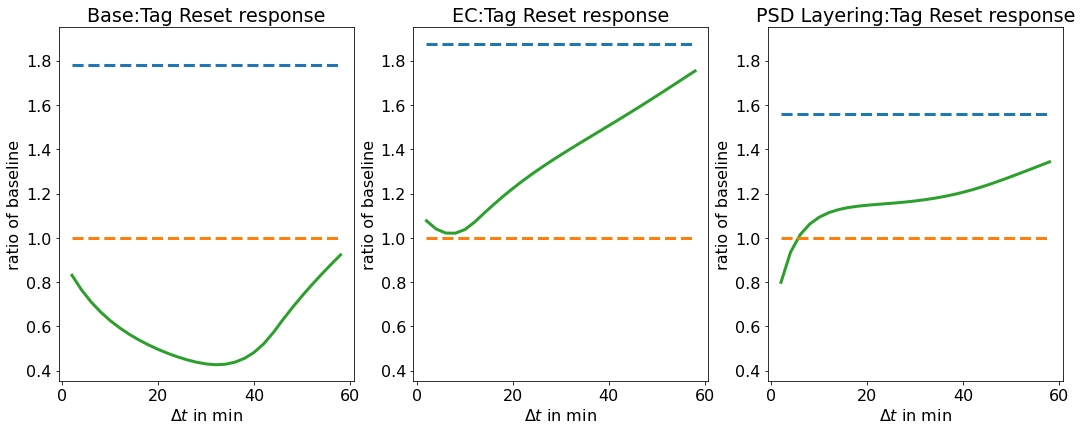

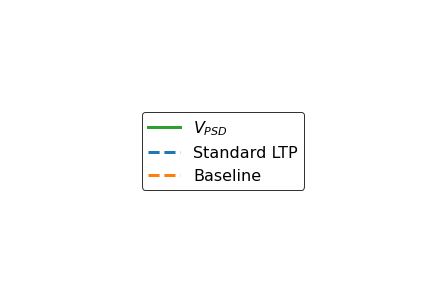

In [ ]:
Sim.plot_selected_points(tr_results,"Vpsd","last",title = "Tag Reset response",event_type="LFS", x_data = x_data, reference_values=reference_values,
                ref_labels = ['Standard LTP','Baseline'],filename = f"none.png",x_label = "t in min",
                multi_plot=3, xlabel = r'$\Delta t$ in min',separate_legend = True,fontsize = 16)

# Metaplasticity experiments and comparison

In [ ]:
# meta_results = []
# for model in ["Base","EC","PSD Layering"]:
#     Sim.switch_model(model)
#     LTP_META = Sim.model.experiments["Metaplasticity"].get_experiment("LTP_META")
#     meta_results.append( Sim.run_experiments(LTP_META)[0])
#     x_data = np.arange(1,len(LTP_META.stim)+1,1)
# print(len(x_data))


In [ ]:
# Sim.plot_selected_points(meta_results,["Vpsd","V_tot"],"last_before_event",["stim","LFS"],
# filename = f"LTP_META.png",x_data = x_data, separate_legend = False, fontsize = 18)

## Linear regression for Vpsd vs Vtot relation

In [ ]:
# from scipy.stats import linregress
# meta_results = []
# V_psd_points = []
# V_tot_points = []
# for k,model in enumerate(["Base", "PSD Layering"]):
#     Sim.switch_model(model)
#     LTP_META = Sim.model.experiments["Metaplasticity"].get_experiment("LTP_META")
#     meta_results = Sim.run_experiments(LTP_META)[0]
#     exp = meta_results["experiment"]
#     V_psd_points.append(meta_results["Vpsd"][[int((s[0]-10)/exp.dt) for s in exp.stim]])
#     V_tot_points.append(meta_results["V_eff"][[int((s[0]-10)/exp.dt) for s in exp.stim]]) 

In [ ]:
# fig = plt.figure(figsize = (12,5))
# for k in range(2):
#     linear_regression = linregress(V_tot_points[k],V_psd_points[k])
#     a = linear_regression.intercept
#     b = linear_regression.slope
#     estimate = [a+V_tot_points[k][i]*b for i in range(len( V_tot_points[k] ))]
#     fig.add_subplot(1,2,k+1)
#     plt.plot(V_tot_points[k], V_psd_points[k], label = "Observed results",lw = 3,color = "#ff4d4d")
#     plt.plot(V_tot_points[k],estimate,ls = '--',alpha = 0.7,color = "k",label = "Regression")

#     plt.title("Base model" if k == 0 else "PSD Layering model")
#     plt.xlabel(r'$V_{tot}$')
#     plt.ylabel(r'$V_{PSD}$')
# plt.legend(loc = "lower left", bbox_to_anchor = (1.0,0))
# plt.tight_layout()
# fig.savefig(f"plots/psd-regression.png")
# plt.show()

In [ ]:
# idx_dict = {
#     "Base" : 0,
#     "PSD Layering": 2,
#     "EC" : 1
# }
# multi = []
# ref = []
# if not isinstance(meta_results,list):
#     meta_results = [meta_results]
# for model in ["Base","EC","PSD Layering"]:
#     idx = idx_dict[model]
#     Sim.switch_model(model)
#     MULTI_LTP = Sim.model.experiments["Multi_LTP"]
#     MULTI_LTP[0].title = "Early LTP Spacing"
#     multi.append(Sim.run_experiments(MULTI_LTP))
#     x_data = np.arange(0,len(MULTI_LTP.experiments),1)
#     times = [int((meta_results[idx]["experiment"].stim[k][0] - 10)/meta_results[idx]["experiment"].dt) for k in range(len( meta_results[idx]["experiment"].stim))]
#     ref.append( [meta_results[idx]["V_tot"][k] for k in times[:len(x_data)]])
# Sim.plot_selected_points(multi,["Vpsd","V_tot"],"last",reference_data = ref,ref_data_labels = "additive",filename="multi-LTP.png",
#                          multi_plot=3,separate_legend = True, fontsize = 18)

In [ ]:
# spacing = []
# reference_values = []
# for model in ["Base","EC","PSD Layering"]:
#     Sim.switch_model(model)
#     LTP_SPACING = Sim.model.experiments["Spacing"]
#     LTP_SPACING[0].title = "LTP spacing"
#     spacing.append(Sim.run_experiments(LTP_SPACING))
#     x_data = [exp.stim[1][1]-300-STET for exp in LTP_SPACING.experiments[1:]]
#     x_data.insert(0,0)
#     x_data = np.array(x_data)/60
#     reference_values.append([spacing[-1][0]["Vpsd"][-1],spacing[-1][-1]["Vpsd"][-1]])
#     reference_labels = [r"$V_{PSD}$ 1xLTP", r"$V_{PSD}$ 2xLTP"]
# Sim.plot_selected_points(spacing,["Vpsd","V_tot"],"last",x_data=x_data, fontsize = 18,
# reference_values = reference_values, ref_labels = reference_labels, filename="LTP-spacing.png",multi_plot = 3,
# xlabel = r'$\Delta t$ in min', separate_legend = True )

In [ ]:
protein_results = []
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    exp = Sim.model.experiments["ProteinTimeLTP"]
    protein_results.append(Sim.run_experiments(exp))

Simulating 81 experiments took: 8.295 s


Making 1 plots
Figsize (14, 6.5)
Making 1 plots


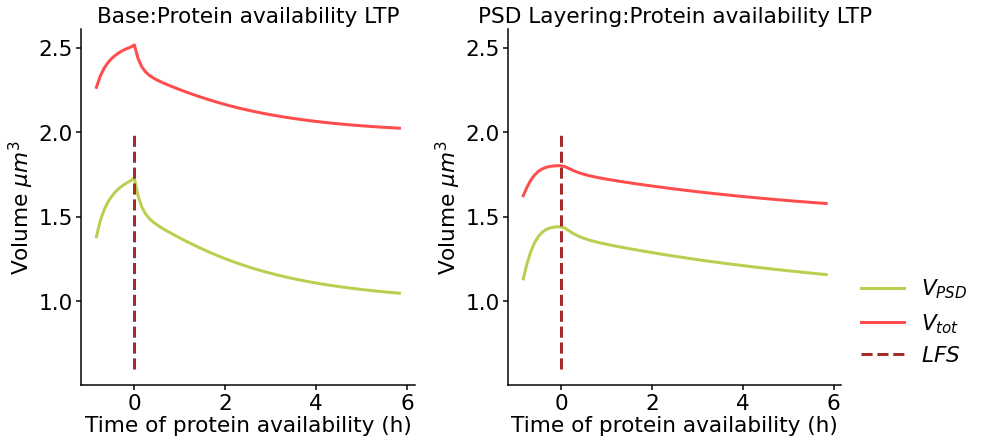

In [ ]:
x_data = (np.arange(900,7*3600,300) - PROTEIN - 300)/3600
Sim.plot_selected_points(protein_results,["Vpsd","V_tot"],"last",["stim"], x_data= x_data,xlabel = "Time of protein availability (h)",
ylabel = r"Volume $\mu m^3$", filename = f"LTP_protein_times_all_models.png", separate_legend = False, fontsize = 18,multi_plot=2)

In [ ]:
protein_results = []
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    exp = Sim.model.experiments["ProteinTimeLTD"]
    protein_results.append(Sim.run_experiments(exp))

Simulating 81 experiments took: 7.432 s
Simulating 81 experiments took: 8.485 s


Making 1 plots
Figsize (14, 6.5)
Making 1 plots


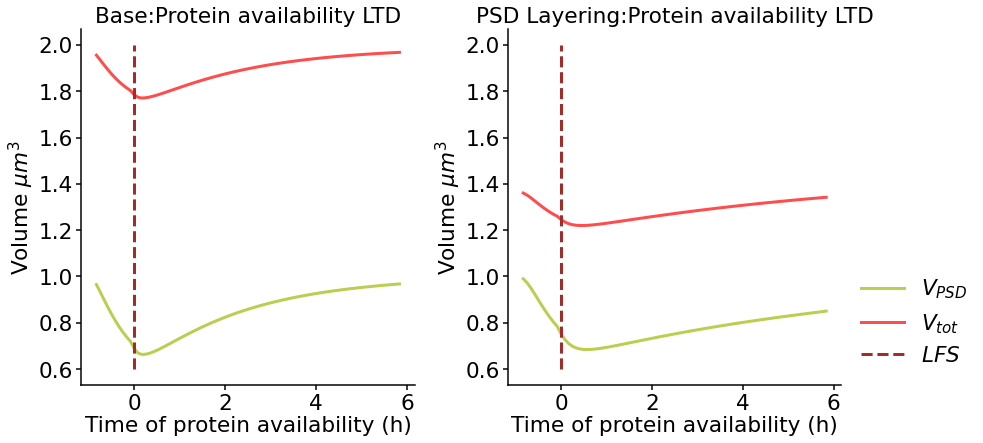

In [ ]:
x_data = (np.arange(900,7*3600,300) - PROTEIN - 300)/3600
Sim.plot_selected_points(protein_results,["Vpsd","V_tot"],"last",["stim"], x_data= x_data,xlabel = "Time of protein availability (h)",
ylabel = r"Volume $\mu m^3$", filename = f"LTD_protein_times_all_models.png", separate_legend = False, fontsize = 18,multi_plot=2)